# Twitter Thesis Project: Analyzing tweets 

## Label your tweets (this is a manual step!)


In order to teach the computer how to classify the tweets automatically, we have to feed the program a lot of tweets together with the class they belong to. These example tweets have to be 'labeled' (given a label that indicates which class they belong to) by someone who can tell the correct class simply from reading the tweet (you). 

These are the steps you can take to prepare your tweet dataset for classification:

- decide on the classes you want to use. 
- number these classes from 0 to the number of classes you have - 1. E.g., if you have 4 classes, you need to use the labels 0,1,2,3. 
- add a column to your dataset (or safer: create a copy of your dataset and add a new column there) where you add the correct label for each of your tweets. To start, try to label at least 100 tweets for each class. It will become clear later on if the classifier needs more examples to learn from. 

**Example: tweets with the keyword 'brussel'**

As an example application, we have collected (through streaming) a number of tweets which contain the keyword 'brussel'. Since the keyword is Dutch, most of the collected tweets are also in Dutch. We would like to train a classifier that automically determines whether a new tweet belongs to one of the following classes: mobility (0), politics or opinion on politics (1), brussels sprouts (2), other (3). We have changed the original file of collected tweets by adding a column with the correct labels. Examples of each class include:

*De trein tussen Brussel en Mechelen, eender welke, da's toch echt roulette spelen: welke komt met het minste vertra… https://t.co/wJ4uXA906d* **(label: 0)**

*@peeters_kris1 @Europarl_NL Mijnheer Peeters, hieronder het nefaste resultaat van de Europese immigratiepolitiek. D… https://t.co/Ia92qNOMcQ* **(label: 1)**

*@GavinWren Tamales
Brussel Sprouts
Lemons* **(label: 2)**

*#Reminder | Over slechts twee dagen vindt de vierde editie van de Mansholtlezing in Brussel plaats over de eiwittra… https://t.co/XJTRGfZhZ* **(label: 3)**





## Load all the additional libraries and tools we will use

In [1]:
import pandas as pd #this is a datascience library that we will use to load and preprocess the tweets
import matplotlib.pyplot as plt #this is a plotting library that we will use to make graphs
from sklearn.feature_extraction.text import TfidfVectorizer #this is a machine learning tool we will use to find a mathematical representation of the tweets
from sklearn.feature_selection import chi2

from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load the tweets you previously collected and annotated

### Load the annotated tweets

In [84]:
tweet_dataset = pd.read_csv('combined_updated_labeled_tweets.csv', delimiter = ';', skiprows = 0) #you can change the name of the file you want to load here

tweet_dataset = tweet_dataset
tweet_dataset.Labeled_Vacancy = tweet_dataset.Labeled_Vacancy.astype(int) #to make sure the labels are correclty read as integer values
tweet_dataset.Label = tweet_dataset.Labeled_Vacancy
tweet_dataset.head() #this will show the top lines in your dataset


,Date,Place_Name,Place_Bounding_Box,Text,Tweet_Id,IsReplyTo_ID,IsReplyTo_Text,Hashtags,Urls,Media,User_Screen_Name,User_Id,User_Followers_Count,Checked_Status_At,Retweets_Count,Favourites_Count,Labeled_Vacancy,Predicted_Vacancy
0,Fri Dec 27 15:13:37 +0000 2019,NaN,NaN,@JoeBiden 700K able bodied single adults that ...,1210579495037677568,1.210261e+18,Donald Trump is cutting food assistance for 70...,NaN,", https://t.co/RVyB56FISy",no,JoeSmit44853256,1180822916348497920,1179,2020-01-10 13:21:40.206939,0,1,0,NaN
1,Fri Dec 27 15:13:37 +0000 2019,NaN,NaN,@bts_bighit Good job ma boys💜💜😍I enjoyed your ...,1210579495524024321,1.210575e+18,[#오늘의방탄] 2019 KBS 가요대축제🕺🏻\nARMY maketh BTS🌂\n파...,NaN,NaN,no,JyselManantan,984970537569894400,11,2020-01-10 13:21:40.206939,0,0,0,NaN
2,Fri Dec 27 15:13:37 +0000 2019,NaN,NaN,@TurkeyFarmersCa @kathryndoan Do you have inte...,1210579495834529793,1.199757e+18,Happy #Thanksgiving tomorrow to our all our fr...,NaN,NaN,no,mostafaelsanta,933392932996108288,40,2020-01-10 13:21:40.206939,0,0,0,NaN
3,Fri Dec 27 15:13:37 +0000 2019,NaN,NaN,@JoeBuscaglia I wouldn’t be upset if Daboll to...,1210579495842983939,1.210362e+18,Both Brian Daboll and Leslie Frazier listed he...,NaN,NaN,no,CoryEberwein,1079946138940252165,0,2020-01-10 13:21:40.206939,0,1,0,NaN
4,Fri Dec 27 15:13:37 +0000 2019,NaN,NaN,@TXT_members BUT THANK YOU FOR TODAY TAEHYUN y...,1210579495813431298,1.210578e+18,가슴이 말해준다 누가 뭐래도 모안 너무 예뻐\n#태현 #Taehyun https:/...,NaN,", https://t.co/s5UlF6Bnnz",no,oesophagustd,1196050020476182528,101,2020-01-10 13:21:40.206939,0,0,0,NaN


### Make a graph of how many tweets per category you have

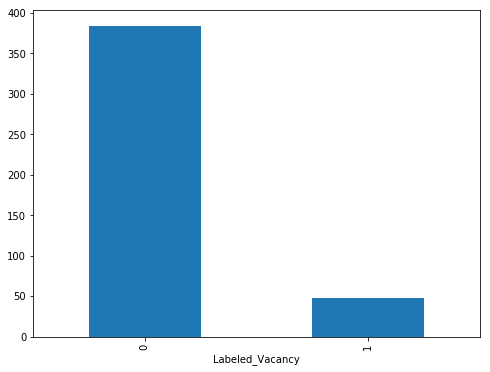

In [85]:
fig = plt.figure(figsize=(8,6))
tweet_dataset.groupby('Labeled_Vacancy').Text.count().plot.bar(ylim=0)
plt.show()

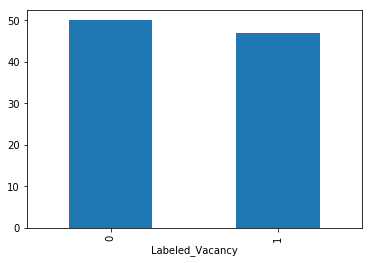

33     Join the Enterprise Holdings team! See our lat...
34     Can you recommend anyone for these 95 #Healthc...
35     Interested in a job in #Mississauga, ON? This ...
41     Pest Control Technical Inspector / Fiel… job a...
46     Fresno CA USA - Regional Marketing Manager - W...
47     #Customer #Support #Applications #Senior #Engi...
48     Banking jobs latest upcoming bank exam vacancy...
69               Another nut job https://t.co/D1BdUkNZKa
83     We have 28 jobs open today at Kelly Services, ...
84     This Business job might be a great fit for you...
88     Align Technology is looking for: Territory Man...
133    The application window is OPEN! Click here to ...
141    Jobs - Nursing Schools &amp; Allied Health Pro...
144    Now hiring for 34 job opportunities at Waste M...
145    #StokeJobs Workshop Manager: Ashtead Plant Hir...
146    Now hiring for 27 #Banking job opportunities i...
150    #StokeJobs Sales Manager - Franchise: https://...
151    Looking for a #SalonCare

In [78]:
# Separate majority and minority classes
df = tweet_dataset; 
df_majority = df[df.Labeled_Vacancy==0]
df_minority = df[df.Labeled_Vacancy==1]
#df_minority = pd.concat([df[df.Label==0],df[df.Label==1],df[df.Label==2]])
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=50,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
    
    

tweet_dataset = df_downsampled;
tweet_dataset.groupby('Labeled_Vacancy').Text.count().plot.bar(ylim=0)
plt.show()


print(tweet_dataset[tweet_dataset.Labeled_Vacancy == 1].Text)



## Convert the tweet texts to an input format the classifier can read

The classifier, i.e., a computer program, will perform certain mathematical operations on each tweet to determine which class it belongs to. We thus have to feed the classifier with a mathematical representation of the tweet. We will used a method called 'bag of words' to find mathemical representations (in the form of **vectors**) for each tweet text. 

### Convert the tweets to vectors

In [81]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(tweet_dataset.Text).toarray()
labels = tweet_dataset.Labeled_Vacancy


### (Intermezzo: Check the important words per class)

In [86]:

#class_to_labels = {
#    'mobility' : 0, 
#    'politics' : 1, 
#    'sprouts' : 2, 
#    'other' : 3
#}

class_to_labels = {
    'other' : 0, 
    'vacancy' : 1, 
}

#category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
#category_to_id = dict(category_id_df.values)
#id_to_category = dict(category_id_df[['category_id', 'Product']].values)
#df.head()


N = 10
for category, label in sorted(class_to_labels.items()):
    features_chi2 = chi2(features, labels==label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'other':
  . Most correlated unigrams:
. apply
. link
. join
. ny
. gt
. click
. good
. looking
. hiring
. jobs
  . Most correlated bigrams:
. click link
. link bio
. gt gt
. good job
. great job
# 'vacancy':
  . Most correlated unigrams:
. apply
. link
. join
. ny
. gt
. click
. good
. looking
. hiring
. jobs
  . Most correlated bigrams:
. click link
. link bio
. gt gt
. good job
. great job


## Train a classifier on the tweets represented as vectors 

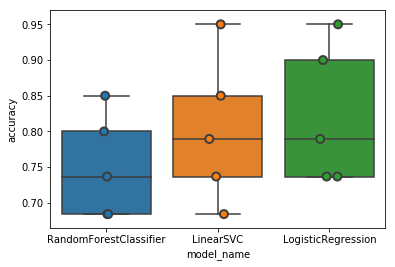

In [87]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [88]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, tweet_dataset.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [97, 97, 431]